# Problems with Monte Carlo integration

By default, we convert "continuous" predictions into grid based predictions by using monte carlo integration: evaluate the kernel at random points and average.

This seems to introduce a large amount of error...  The following demonstrates this with artificial, random data.  However, I noticed this problem on data from Chicago.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import open_cp.retrohotspot
import open_cp.data
import open_cp.predictors
import open_cp.evaluation

In [2]:
n = 1000
times = np.random.random(n) * 365
times = times * (np.timedelta64(1, "D") / np.timedelta64(1, "s")) * np.timedelta64(1, "s")
times = np.sort(np.datetime64("2016-01-01") + times)
points = open_cp.data.TimedPoints(times, np.random.random((2,n)) * 1000)

In [3]:
mask = [[False]*100]*100
grid = open_cp.data.MaskedGrid(10, 10, 0, 0, mask)

In [4]:
predictor = open_cp.retrohotspot.RetroHotSpot()
predictor.data = points
predictor.weight = open_cp.retrohotspot.TruncatedGaussian(100, 10)
cts_pred = predictor.predict(end_time=np.datetime64("2016-10-01"))
cts_pred.samples = 5
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(cts_pred, grid)

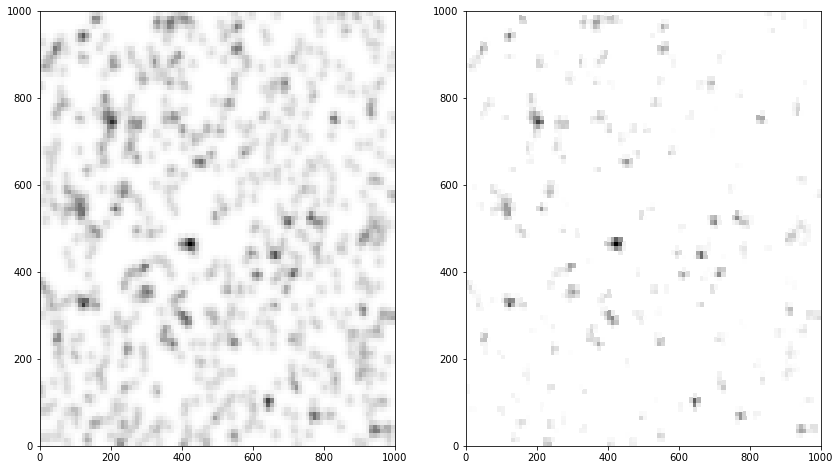

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(14,8))

ax[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys")
p = open_cp.evaluation.top_slice_prediction(pred, 0.1)
ax[1].pcolor(*p.mesh_data(), p.intensity_matrix, cmap="Greys")

Repeat: Form the prediction again, top slice the top 10% of risk again, and compare the selected cells (same as looking at the "mask" of the top sliced prediction.  They differ by a lot!)

In [6]:
cts_pred = predictor.predict(end_time=np.datetime64("2016-10-01"))
cts_pred.samples = 5
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(cts_pred, grid)
p1 = open_cp.evaluation.top_slice_prediction(pred, 0.1)

In [7]:
np.sum(p.intensity_matrix.mask ^ p.intensity_matrix.mask)

0

In [8]:
np.sum(p1.intensity_matrix.mask ^ p1.intensity_matrix.mask)

0

In [9]:
np.sum(p.intensity_matrix.mask ^ p1.intensity_matrix.mask)

224

You might argue that 5 samples is too small...

In [10]:
cts_pred = predictor.predict(end_time=np.datetime64("2016-10-01"))
cts_pred.samples = 25
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(cts_pred, grid)
p = open_cp.evaluation.top_slice_prediction(pred, 0.1)

cts_pred = predictor.predict(end_time=np.datetime64("2016-10-01"))
cts_pred.samples = 25
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(cts_pred, grid)
p1 = open_cp.evaluation.top_slice_prediction(pred, 0.1)

In [11]:
np.sum(p.intensity_matrix.mask ^ p1.intensity_matrix.mask)

86

We have added a "reproducible" mode, whereby we don't sample at random points, but rather on a regular sub-grid

In [12]:
cts_pred = predictor.predict(end_time=np.datetime64("2016-10-01"))
cts_pred.samples = -5
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(cts_pred, grid)
p = open_cp.evaluation.top_slice_prediction(pred, 0.1)

cts_pred = predictor.predict(end_time=np.datetime64("2016-10-01"))
cts_pred.samples = -5
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(cts_pred, grid)
p1 = open_cp.evaluation.top_slice_prediction(pred, 0.1)

In [13]:
np.sum(p.intensity_matrix.mask ^ p1.intensity_matrix.mask)

0